In [517]:
import pandas as pd
import numpy as np
import os
import getpass
import re
import nltk
import tqdm
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import swifter
import matplotlib as plt
import matplotlib.pyplot as plt 
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras import optimizers
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

In [518]:
df = pd.read_csv("Merged_Finall.csv")
df = df[df["Date"] > "2014-01-01"]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")

In [519]:
df["prev_close"] = df["Close"].shift(+1)
df["prev2_close"] = df["Close"].shift(+2)
df["prev3_close"] = df["Close"].shift(+3)
df["prev4_close"] = df["Close"].shift(+4)
df["prev5_close"] = df["Close"].shift(+5)
df = df.dropna()

In [520]:
seen_df= df[:int(len(df) * 0.80)]
unseen_df = df[int(len(df) * 0.80):]
print(f"Records in seen Dataframe -> {len(seen_df)} and records in unseen Dataframe -> {len(unseen_df)}")

Records in seen Dataframe -> 1717 and records in unseen Dataframe -> 430


In [521]:
split_date = seen_df.iloc[int(len(seen_df) * 0.9)]['Date']
df_train = seen_df.loc[seen_df.Date <= split_date].copy()
df_test = seen_df.loc[seen_df.Date > split_date].copy()

In [522]:
X_train = df_train[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
y_train = df_train["Close"]

X_test = df_test[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
y_test = df_test["Close"]

unseen_X_test = unseen_df[["prev_close", "prev2_close", "prev3_close", "prev4_close", "prev5_close", "FinalScore", "Volume"]]
unseen_y_test = unseen_df["Close"]

In [523]:
reg = xgb.XGBRegressor(n_estimators=20000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=5000,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [524]:
unseen_df['Prediction'] = reg.predict(unseen_X_test)

/tmp/ipykernel_913390/371211560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_df['Prediction'] = reg.predict(unseen_X_test)


In [525]:
unseen_df = unseen_df[["Date", "Close", "Prediction"]]
unseen_df

,Date,Close,Prediction
1970,2018-09-20,6519.670000,6138.039551
1971,2018-09-21,6734.950000,6632.335449
1972,2018-09-22,6721.980000,7084.864746
1973,2018-09-23,6710.630000,7084.864746
1974,2018-09-24,6595.410000,7084.864746
...,...,...,...
2395,2019-11-19,8206.145918,7819.322754
2396,2019-11-20,8027.268243,7819.322754
2397,2019-11-21,7642.749945,7819.322754
2398,2019-11-22,7296.577568,7805.002441


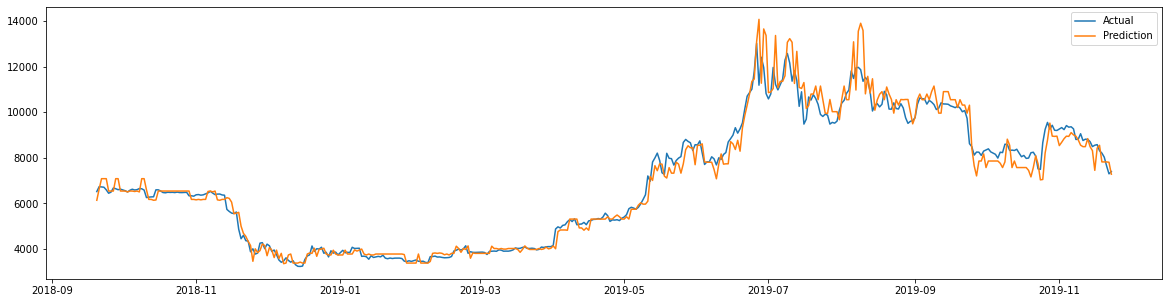

In [526]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(unseen_df["Date"], unseen_df["Close"], label = "Actual")
plt.plot(unseen_df["Date"], unseen_df["Prediction"], label = "Prediction")
plt.legend()

In [527]:
merged_df = unseen_df[["Date", "Close", "Prediction"]]
merged_df.columns = ["Date", "Actual", "Prediction"]
merged_df

,Date,Actual,Prediction
1970,2018-09-20,6519.670000,6138.039551
1971,2018-09-21,6734.950000,6632.335449
1972,2018-09-22,6721.980000,7084.864746
1973,2018-09-23,6710.630000,7084.864746
1974,2018-09-24,6595.410000,7084.864746
...,...,...,...
2395,2019-11-19,8206.145918,7819.322754
2396,2019-11-20,8027.268243,7819.322754
2397,2019-11-21,7642.749945,7819.322754
2398,2019-11-22,7296.577568,7805.002441


In [528]:
merged_df["Actual_prev"] = merged_df["Actual"].shift(+1)
merged_df["Pred_prev"] = merged_df["Prediction"].shift(+1)
merged_df = merged_df.dropna()

In [529]:
merged_df

,Date,Actual,Prediction,Actual_prev,Pred_prev
1971,2018-09-21,6734.950000,6632.335449,6519.670000,6138.039551
1972,2018-09-22,6721.980000,7084.864746,6734.950000,6632.335449
1973,2018-09-23,6710.630000,7084.864746,6721.980000,7084.864746
1974,2018-09-24,6595.410000,7084.864746,6710.630000,7084.864746
1975,2018-09-25,6446.470000,6542.854492,6595.410000,7084.864746
...,...,...,...,...,...
2395,2019-11-19,8206.145918,7819.322754,8309.285983,8548.419922
2396,2019-11-20,8027.268243,7819.322754,8206.145918,7819.322754
2397,2019-11-21,7642.749945,7819.322754,8027.268243,7819.322754
2398,2019-11-22,7296.577568,7805.002441,7642.749945,7819.322754


In [530]:
merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
merged_df['Pred_target'] = merged_df[['Prediction','Pred_prev']].apply(lambda x: 1 if x.Prediction > x.Pred_prev else 0, axis=1)

/tmp/ipykernel_913390/2833640580.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Actual_target'] = merged_df[['Actual','Actual_prev']].apply(lambda x: 1 if x.Actual > x.Actual_prev else 0, axis=1)
/tmp/ipykernel_913390/2833640580.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Pred_target'] = merged_df[['Prediction','Pred_prev']].apply(lambda x: 1 if x.Prediction > x.Pred_prev else 0, axis=1)


In [531]:
merged_df

,Date,Actual,Prediction,Actual_prev,Pred_prev,Actual_target,Pred_target
1971,2018-09-21,6734.950000,6632.335449,6519.670000,6138.039551,1,1
1972,2018-09-22,6721.980000,7084.864746,6734.950000,6632.335449,0,1
1973,2018-09-23,6710.630000,7084.864746,6721.980000,7084.864746,0,0
1974,2018-09-24,6595.410000,7084.864746,6710.630000,7084.864746,0,0
1975,2018-09-25,6446.470000,6542.854492,6595.410000,7084.864746,0,0
...,...,...,...,...,...,...,...
2395,2019-11-19,8206.145918,7819.322754,8309.285983,8548.419922,0,0
2396,2019-11-20,8027.268243,7819.322754,8206.145918,7819.322754,0,0
2397,2019-11-21,7642.749945,7819.322754,8027.268243,7819.322754,0,0
2398,2019-11-22,7296.577568,7805.002441,7642.749945,7819.322754,0,0


In [532]:
act = list(merged_df["Actual_target"])
pred = list(merged_df["Pred_target"])

In [533]:
hit = 0
miss = 0
for i in range(len(act)):
    if act[i] == pred[i]:
        hit+=1
    else:
        miss+=1
print(f"total hits are {hit} and total misses are {miss}")

total hits are 214 and total misses are 215


In [534]:
X_train

,prev_close,prev2_close,prev3_close,prev4_close,prev5_close,FinalScore,Volume
253,953.289978,933.530029,859.510010,818.719971,802.390015,0.137522,8.131170e+07
254,802.000000,953.289978,933.530029,859.510010,818.719971,0.118022,7.417560e+07
255,842.719971,802.000000,953.289978,933.530029,859.510010,0.152745,5.999860e+07
256,846.859985,842.719971,802.000000,953.289978,933.530029,0.163590,3.187680e+07
257,868.479980,846.859985,842.719971,802.000000,953.289978,0.161135,4.475420e+07
...,...,...,...,...,...,...,...
1794,7833.040039,8209.400391,8495.780273,8668.120117,8879.620117,1012.278445,4.935290e+09
1795,7954.479980,7833.040039,8209.400391,8495.780273,8668.120117,722.102533,6.361230e+09
1796,7165.700195,7954.479980,7833.040039,8209.400391,8495.780273,85.890406,6.289510e+09
1797,6890.520020,7165.700195,7954.479980,7833.040039,8209.400391,-489.467046,4.553270e+09


In [535]:
X_test

,prev_close,prev2_close,prev3_close,prev4_close,prev5_close,FinalScore,Volume
1799,6844.229980,6973.529785,6890.520020,7165.700195,7954.479980,63.903832,4.333440e+09
1800,7083.799805,6844.229980,6973.529785,6890.520020,7165.700195,162.256324,5.499700e+09
1801,7456.109863,7083.799805,6844.229980,6973.529785,6890.520020,115.748846,4.936000e+09
1802,6853.839844,7456.109863,7083.799805,6844.229980,6973.529785,-58.217505,5.639320e+09
1803,6811.470215,6853.839844,7456.109863,7083.799805,6844.229980,100.485424,3.766810e+09
...,...,...,...,...,...,...,...
1965,6512.710000,6517.310000,6351.800000,6321.200000,6329.700000,-115907.078333,3.216300e+09
1966,6543.200000,6512.710000,6517.310000,6351.800000,6321.200000,2109.077529,3.273730e+09
1967,6517.180000,6543.200000,6512.710000,6517.310000,6351.800000,-10197.911358,3.910780e+09
1968,6281.200000,6517.180000,6543.200000,6512.710000,6517.310000,258.892005,4.180090e+09


In [536]:
unseen_X_test

,prev_close,prev2_close,prev3_close,prev4_close,prev5_close,FinalScore,Volume
1970,6398.540000,6371.300000,6281.200000,6517.180000,6543.200000,-231.044312,4.348110e+09
1971,6519.670000,6398.540000,6371.300000,6281.200000,6517.180000,-235.512001,6.531940e+09
1972,6734.950000,6519.670000,6398.540000,6371.300000,6281.200000,282.009920,4.509660e+09
1973,6721.980000,6734.950000,6519.670000,6398.540000,6371.300000,44.048711,4.197500e+09
1974,6710.630000,6721.980000,6734.950000,6519.670000,6398.540000,152.022162,4.177310e+09
...,...,...,...,...,...,...,...
2395,8309.285983,8577.975782,8550.760557,8491.992012,8708.095095,266.234714,2.108361e+10
2396,8206.145918,8309.285983,8577.975782,8550.760557,8491.992012,10.221575,2.076430e+10
2397,8027.268243,8206.145918,8309.285983,8577.975782,8550.760557,-8503.435071,2.251424e+10
2398,7642.749945,8027.268243,8206.145918,8309.285983,8577.975782,15.649639,3.424232e+10
